In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, countmap
using Statistics

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, Strategy, C

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="serif-roman",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
);

In [3]:
function area_C_rate(N::Int, strategy_mat::Matrix{Strategy}, t::Int, span::Int, rich_flag::Bool)::Float64
    # prime node or the poorest node
    prime_node_id = 1
    node = rich_flag ? prime_node_id : ((prime_node_id + Int(N / 2)) % N)

    strategy_vec = if node + span > N
        [strategy_mat[t, (node - span):N]; strategy_mat[t, 1:(node + span) % N]]
    elseif node - span < 1
        [strategy_mat[t, (node - span + N):N]; strategy_mat[t, 1:(node + span)]]
    else
        strategy_mat[t, (node - span):(node + span)]
    end

    return mean(strategy_vec .== C)
end

function moving_average(data::Vector{Float64}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

function calc_cross_cor(x::Vector{Float64}, y::Vector{Float64}, lag_vec::StepRange{Int64, Int64})::Vector{Float64}
    l = min(length(x), length(y))
    max_lag = maximum(lag_vec)

    if l <= max_lag
        @show x
        @show y
        return [0.0]
    end

    _x = x[(end - l + 1):end]
    _y = y[(end - l + 1):end]
    return [cor(_x[(max_lag+1):(end-max_lag)], _y[(max_lag+1+lag):(end-max_lag+lag)]) for lag in lag_vec]
end;

In [4]:
trials = 10
p = Param(
    N = 100,
    k₀ = 4,
    generations = 100_000,
    C_rate₀ = 0.0,
    relationship_increment_factor = 1.1,
    resource_decrement_factor = 0.02,
    resource_limit_μ = 0.5,
    b = 1.0,
    peak_node_variability = 8,
    resource_limit_β = 0.0,
    resource_limit_σ = 0.0,
)
C_rate_vec_vec = []
peak_node_vec_vec = []
degree_mat_vec = []

# Execute simulations
for _ in 1:trials
    random_seed = rand(1:typemax(Int16))
    m = Model(p, MersenneTwister(random_seed))
    C_rate_vec, _, _, peak_node_vec, _, degree_mat = run!(m, MersenneTwister(random_seed))

    push!(C_rate_vec_vec, C_rate_vec)
    push!(peak_node_vec_vec, peak_node_vec)
    push!(degree_mat_vec, degree_mat)
end;

In [5]:
time_lag_vec = -50:1:50
cross_cor_C_rate_hub_count_vec_vec = []
cross_cor_C_rate_degree_SD_vec_vec = []
cross_cor_env_C_rate_vec_vec = []
cross_cor_env_hub_count_vec_vec = []
cross_cor_env_degree_SD_vec_vec = []

for i in 1:trials
    # Variables
    C_rate_vec = C_rate_vec_vec[i]
    C_rate_var_vec = C_rate_vec[2:end] .- C_rate_vec[1:(end-1)]
    degree_mat = degree_mat_vec[i]
    degree_SD_vec = vec(std(degree_mat, dims=2))
    hub_count_vec = Float64.([sum(degree_mat[x, :] .>= 8) for x in 1:size(degree_mat, 1)])
    peak_node_vec = peak_node_vec_vec[i]
    prime_node_shift_vec = Float64.(abs.(peak_node_vec[2:end] .- peak_node_vec[1:(end-1)]))
    prime_node_shift_vec = [x > 50 ? 100 - x : x for x in prime_node_shift_vec]

    # Moving average
    window_size = 10
    moving_C_rate_vec = moving_average(C_rate_vec, window_size)
    moving_degree_SD_vec = moving_average(degree_SD_vec, window_size)
    moving_hub_count_vec = moving_average(hub_count_vec, window_size)
    moving_prime_node_shift_vec = moving_average(prime_node_shift_vec, window_size)

    # Cross-correlation
    push!(cross_cor_C_rate_hub_count_vec_vec, calc_cross_cor(moving_C_rate_vec, moving_hub_count_vec, time_lag_vec))
    push!(cross_cor_C_rate_degree_SD_vec_vec, calc_cross_cor(moving_C_rate_vec, moving_degree_SD_vec, time_lag_vec))
    push!(cross_cor_env_C_rate_vec_vec, calc_cross_cor(moving_prime_node_shift_vec, moving_C_rate_vec, time_lag_vec))
    push!(cross_cor_env_hub_count_vec_vec, calc_cross_cor(moving_prime_node_shift_vec, moving_hub_count_vec, time_lag_vec))
    push!(cross_cor_env_degree_SD_vec_vec, calc_cross_cor(moving_prime_node_shift_vec, moving_degree_SD_vec, time_lag_vec))
end;

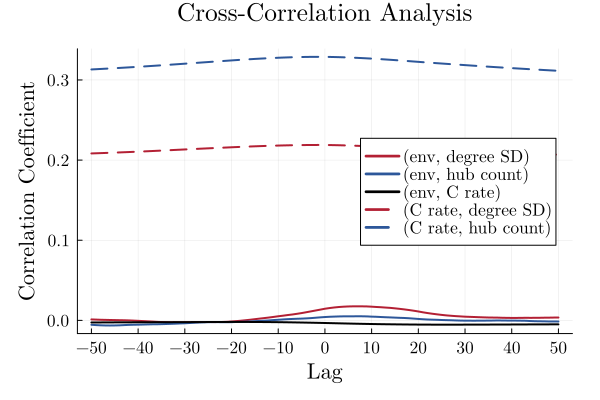

Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行


In [6]:
mean_C_rate_hub_count_vec = [mean([cross_cor_C_rate_hub_count_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_C_rate_hub_count_vec = [std([cross_cor_C_rate_hub_count_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
mean_C_rate_degree_SD_vec = [mean([cross_cor_C_rate_degree_SD_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_C_rate_degree_SD_vec = [std([cross_cor_C_rate_degree_SD_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
mean_env_C_rate_vec = [mean([cross_cor_env_C_rate_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_env_C_rate_vec = [std([cross_cor_env_C_rate_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
mean_env_hub_count_vec = [mean([cross_cor_env_hub_count_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_env_hub_count_vec = [std([cross_cor_env_hub_count_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
mean_env_degree_SD_vec = [mean([cross_cor_env_degree_SD_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_env_degree_SD_vec = [std([cross_cor_env_degree_SD_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]

# Plot base
plt = plot(
    xticks=minimum(time_lag_vec):10:maximum(time_lag_vec),
    xlabel="Lag",
    yticks=-0.2:0.1:1.0,
    ylabel="Correlation Coefficient",
    title="Cross-Correlation Analysis",
    legend=:right,
)

function plot_cross_correlation!(plt::Plots.Plot, time_lag_vec::AbstractVector, mean_vec::Vector{Float64}, std_vec::Vector{Float64}, label::String, color::String, style::Symbol)::Nothing
    # plot!(plt, time_lag_vec, mean_vec, ribbon=std_vec, label=label, lc=color, lw=2, linestyle=style, fillcolor=color)
    plot!(plt, time_lag_vec, mean_vec, label=label, lc=color, lw=2, linestyle=style, fillcolor=color)
    
    return
end

# Plot cross-correlation
plot_cross_correlation!(plt, time_lag_vec, mean_env_degree_SD_vec,    std_env_degree_SD_vec,    "(env, degree SD)",    "#B32034", :solid)
plot_cross_correlation!(plt, time_lag_vec, mean_env_hub_count_vec,    std_env_hub_count_vec,    "(env, hub count)",    "#2D579A", :solid)
plot_cross_correlation!(plt, time_lag_vec, mean_env_C_rate_vec,       std_env_C_rate_vec,       "(env, C rate)",       "#000000", :solid)
plot_cross_correlation!(plt, time_lag_vec, mean_C_rate_degree_SD_vec, std_C_rate_degree_SD_vec, "(C rate, degree SD)", "#B32034", :dash)
plot_cross_correlation!(plt, time_lag_vec, mean_C_rate_hub_count_vec, std_C_rate_hub_count_vec, "(C rate, hub count)", "#2D579A", :dash)

display(plt)
# savefig(plt, "img/cross_cor_regional.png")
println("Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行");

In [7]:
mean.([C_rate_vec[Int(end/2):end] for C_rate_vec in C_rate_vec_vec])

10-element Vector{Float64}:
 0.3296512069758605
 0.2375362492750145
 0.17818183636327276
 0.2864926701465971
 0.20309533809323813
 0.1403905921881562
 0.1806437871242575
 0.34485570288594225
 0.265662486750265
 0.210262594748105

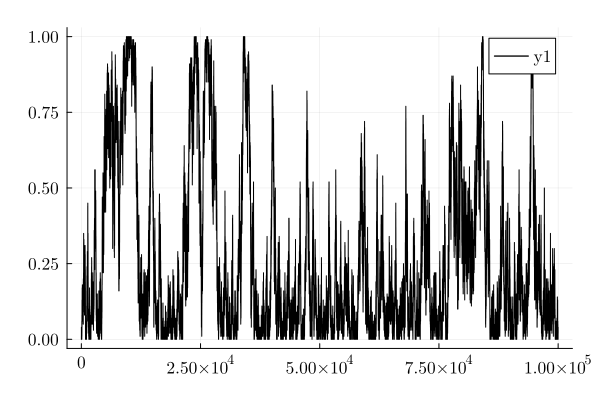

In [8]:
plot(C_rate_vec_vec[5], lc=:black)